In [11]:
import torch
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image

data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './DATA/pacs/images'
'''
image_datasets = datasets.ImageFolder(data_dir, data_transform)
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=2048,
                                             shuffle=True, num_workers=4)
'''

domains = [name for name in os.listdir(data_dir) if not name.startswith('.')]
class_name = sorted([name for name in os.listdir(os.path.join(data_dir, domains[0])) if not name.startswith('.')])
label = []
data_list = []
batch_class = 64

for domain in domains:
    for i, class_iter in enumerate(class_name):
        image_list = [image_name for image_name in sorted(os.listdir(os.path.join(data_dir, domain, class_iter))) if not image_name.startswith('.')]
        for index in range(batch_class):
            data_list.append(data_transform(Image.open(os.path.join(data_dir, domain, class_iter, image_list[index]))))
        label.extend([i]*batch_class)

In [12]:
input_data = torch.stack(data_list, dim=0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(input_data[0:1792:32])

imshow(out)


In [21]:
from collections import OrderedDict

from dassl.modeling.backbone.uresnet import uresnet18

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = uresnet18(pretrained=False)
model_path = './output/dg/pacs_batch_compare/corruncertainty_uresnet18_a012345d3_64/art_painting/model/model.pth.tar-50'
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['state_dict']
renew_weight =  OrderedDict()
for key in state_dict.keys():
    if key.startswith('backbone'):
        renew_weight[key[9:]] = state_dict[key]

model_ft.load_state_dict(renew_weight)

<All keys matched successfully>

In [ ]:
from collections import OrderedDict
from sklearn.manifold import TSNE
from dassl.modeling.backbone.uresnet import uresnet18

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = uresnet18(pretrained=False)
label_np = np.expand_dims(np.asarray(label, dtype=np.float32), axis=1)
out_dict = {}
out_dict['label'] = label_np
out_dict['domains'] = domains

for domain in domains:
    model_path = f'./output/dg/pacs_batch_compare/corruncertainty_uresnet18_a012345d3_64/{domain}/model/model.pth.tar-50'
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['state_dict']
    renew_weight =  OrderedDict()
    for key in state_dict.keys():
        if key.startswith('backbone'):
            renew_weight[key[9:]] = state_dict[key]

    model_ft.load_state_dict(renew_weight)
    out_features = model_ft(input_data)
    out_features_np =out_features.detach().numpy()
    data_np = np.squeeze(out_features_np).astype(np.float32)
    X = np.concatenate([data_np, label_np], axis=1)
    X_embedded = TSNE(n_components=2, init='random', perplexity=30).fit_transform(X)
    out_dict[domain] = X_embedded

In [ ]:
import pickle

with open('out_data', 'w') as f:
    pickle.dump(out_dict, f)

In [22]:
input_data = input_data
out_features = model_ft(input_data)

In [23]:
out_features_np =out_features.detach().numpy()

In [24]:
from sklearn.manifold import TSNE

label_np = np.expand_dims(np.asarray(label, dtype=np.float32), axis=1)
data_np = np.squeeze(out_features_np).astype(np.float32)
X = np.concatenate([data_np, label_np], axis=1)
X_embedded = TSNE(n_components=2, init='random', perplexity=30).fit_transform(X)

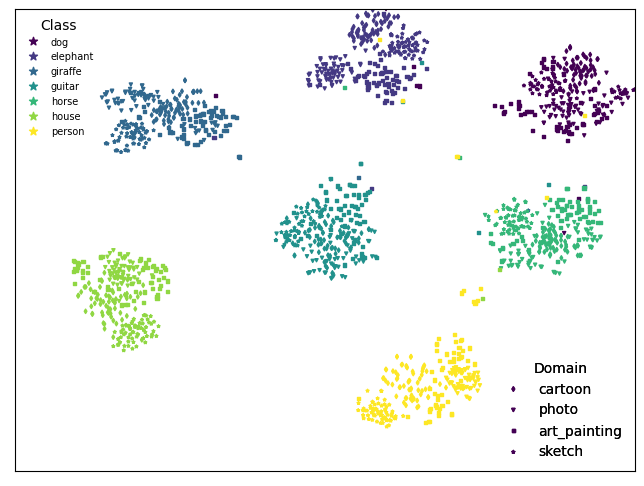

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))

marker_list = ["d", "v", "s", "*"]
sc_list = []
for i, domain in enumerate(domains):
    sc = ax.scatter(X_embedded[(i*7*64):((i+1)*7*64), 0], X_embedded[(i*7*64):((i+1)*7*64), 1], c=label[(i*7*64):((i+1)*7*64)], s=5, marker=marker_list[i])
    sc_list.append(sc)

plt.grid(False)
ax.set_xlim((np.min(X_embedded[:,0])*1.2, np.max(X_embedded[:,0])*1.))
ax.set_ylim((np.min(X_embedded[:,1])*1.2, np.max(X_embedded[:,1])*1.))
ax.set_xticks([])
ax.set_yticks([])
legend_prop = [*sc.legend_elements()]
legend_prop[1] = class_name
legend1 = ax.legend(*legend_prop, loc="upper left", title="Class", prop={'size': 7})
legend1.get_frame().set_facecolor('none')
legend1.get_frame().set_linewidth(0.0)
ax.add_artist(legend1)
legend2 = ax.legend(sc_list, domains, loc="lower right", title="Domain")
ax.add_artist(legend2)
legend2.get_frame().set_facecolor('none')
legend2.get_frame().set_linewidth(0.0)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

eps = 1e-6

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(2, 2,  width_ratios=(1, 1), height_ratios=(2, 1)) 
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# spans two rows:
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

C = out_features.size(1)
mu_squeeze = np.mean(out_features_np, axis=(2, 3))
mean_mu = np.mean(mu_squeeze, axis=0, keepdims=True)
correlation_mu = (mu_squeeze.T-mean_mu.T) @ (mu_squeeze-mean_mu) / C
norm_factor = np.diag(1./np.sqrt(np.diag(correlation_mu) + eps))
correlation_mu_out = norm_factor @ correlation_mu@ norm_factor

sig_squeeze = np.std(out_features_np, axis=(2, 3))
mean_sig = np.std(sig_squeeze, axis=0, keepdims=True)
correlation_sig = (sig_squeeze.T-mean_sig.T) @ (sig_squeeze-mean_sig) / C
norm_factor = np.diag(1./np.sqrt(np.diag(correlation_sig) + eps))
correlation_sig_out = norm_factor @ correlation_sig@ norm_factor

im1 = ax1.imshow(correlation_mu_out, cmap='cool', vmin=-1., vmax=1.)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('bottom', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='horizontal')
ax1.set_title('Correlation between Style Mean')
ax1.set_axisbelow(False)
#ax[0, 0].colorbar()
im2 = ax2.imshow(correlation_sig_out, cmap='cool', vmin=-1., vmax=1.)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('bottom', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='horizontal')
ax2.set_title('Correlation between Style Std')
#ax[0, 1].colorbar()
eng_value_mu, _ = np.linalg.eigh(correlation_mu_out)
eng_value_sig, _ = np.linalg.eigh(correlation_sig_out)
x = range(128)[::-1]
ax3.plot(x, eng_value_mu, lw=3)
ax3.plot(x, [np.max(eng_value_mu)*0.01]*len(x), '--', lw=3)
ax3.legend(['Engenvalue', r'1% of Maximum'])
ax3.fill_between(x, 0, eng_value_mu, alpha=0.5)
ax3.set_xlim([0, 127])
ax3.set_ylim([1e-2, 1e2])
ax3.set_yscale('log')

ax4.plot(x, eng_value_sig, lw=3)
ax4.plot(x, [np.max(eng_value_sig)*0.01]*len(x), '--', lw=3)
ax4.legend(['Engenvalue', r'1% of Maximum'])
ax4.fill_between(x, 0, eng_value_sig, alpha=0.5)
ax4.set_xlim([0, 127])
ax4.set_ylim([1e-2, 1e2])
ax4.set_yscale('log')
plt.tight_layout()
plt.savefig('Correlation_visualization.pdf')

In [ ]:
eng_value, eng_vector = np.linalg.eigh(correlation_mu_out)
plt.stem(eng_value)
plt.yscale('log')